### Animated map which displays the protests locations in sequence
With:
- ##### <u> SQLDATE </u>
- ##### <u> ActionGeo_Lat </u>
- ##### <u> ActionGeo_Long </u>

In [80]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import os
from IPython.core.display import display, HTML
from functions.animated_maps_functions import *
from functions.dataframe_functions import *

import folium

import matplotlib.pyplot as plt


DATA_PATH = "data/"
ANIMATED_MAP_PATH = 'maps/animated_maps/'
WORLD_MAP_TYPE_PATH = ANIMATED_MAP_PATH + 'world_map_type/'
WORLD_MAP_FREQ_PATH = ANIMATED_MAP_PATH + 'world_map_freq/'
COUNTRY_MAP_PATH = ANIMATED_MAP_PATH + 'individual_country_map/'
FOLIUM_MAPS_PATH = "maps/folium_maps/"

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'C:\\Users\\antho\\Downloads\\adafinalproject-b2214ea058a4.json'
bigquery_client = bigquery.Client()

In [81]:
#Fetching data from GDELT
## BIG DATA, 3 000 000 rows

if os.path.isfile(DATA_PATH + 'protests_location.csv') :
    #If we already saved the data, don't run the query again, just get the data from the file saved previously
    protests_df_location = pd.read_csv(DATA_PATH + 'protests_location.csv')
else:
    #query to get the date and the location of the protest events
    #Remark: '14%' filters the protest events because they all start by '14'
    query_protests_location = bigquery_client.query(
        """SELECT SQLDATE, ActionGeo_Lat, ActionGeo_Long, EventCode, ActionGeo_FullName  FROM `gdelt-bq.gdeltv2.events` 
        WHERE EventCode LIKE '14%' """)
    protests_df_location = query_protests_location.result().to_dataframe()
    # Write down a csv file
    protests_df_location.to_csv(DATA_PATH + 'protests_location.csv', index=False)
protests_df_location = protests_df_location.dropna()
print("The number of protests we got is: " + str(protests_df_location['EventCode'].count()))

The number of protests we got is: 1769903


## Animated world map: visualyzing the kind of protest
Displaying a dynamic world map which shows evolution day by day
I also allows to see which kind of protest it is thanks to color indicators

In [82]:
#Extracting ActionGeo_Lat and ActionGeo_Long
protests_without_duplicated_values = protests_df_location
#protests_without_duplicated_values['ActionGeo_Lat'] = protests_df_location['ActionGeo_Lat']
#protests_without_duplicated_values['ActionGeo_Long'] = protests_df_location['ActionGeo_Long']

#Removing duplicated values 
#The values are not really duplicated, they took place on different day
#however we don't want to display a circle within another, we only want to visualyze the kind of protest
#we will visualize the frequency on the next two maps
protests_without_duplicated_values=protests_without_duplicated_values.drop_duplicates(subset=['ActionGeo_Long', 'ActionGeo_Lat', 'EventCode'], keep=False)
protests_without_duplicated_values=protests_without_duplicated_values.sort_values('SQLDATE')
protests_without_duplicated_values = filtering_df_date_country(protests_without_duplicated_values,date_start = 20140325,date_end = 20150800)

In [83]:
#getting only the first 3 digits of event code because we don't mind the other, they provide useless information for our analysis
protests_without_duplicated_values['EventCode']= protests_without_duplicated_values['EventCode'].astype(str)
protests_without_duplicated_values['EventCode']= protests_without_duplicated_values['EventCode'].str[0:3]

In [84]:
#getting a df in an appropriate format
protests_df_for_js = pd.DataFrame()
protests_df_for_js["coord_for_js"] = '[' + protests_without_duplicated_values['ActionGeo_Lat'].astype(str) + ',' + protests_without_duplicated_values['ActionGeo_Long'].astype(str) + '],'
protests_df_for_js["dates"] = protests_without_duplicated_values['SQLDATE'].astype(str)
protests_df_for_js["dates"] = '[' + protests_df_for_js['dates'].str[0:4] + protests_df_for_js['dates'].str[4:6] + protests_df_for_js['dates'].str[6:8] + '],'
protests_df_for_js["event_code"] = protests_without_duplicated_values['EventCode'].astype(str)
protests_df_for_js["event_code"] = '[' + protests_df_for_js['event_code'] + '],'

In [85]:
#Updating the js script to display result on a dynamic world map
updating_js_script(protests_df_for_js, WORLD_MAP_TYPE_PATH, markers_speed=0.1)

In [86]:
display(HTML("<h1><a href='"+WORLD_MAP_TYPE_PATH+"index.html' target='_blank'>Animated map that displays protests day by day (Ctrl+Click)</a></h1>"))

## Animated world map: visualyzing the frequency
Displaying a dynamic world map which shows how often we get a protest on an area.
The color goes from white to green then black. Areas in white color means few protests took place here, black means the opposite.

In [87]:
protests_world_wanted = filtering_df_date_country(protests_df_location,date_start = 20150201,date_end = 20150220)
protests_world_wanted=protests_world_wanted.sort_values('SQLDATE')

In [88]:
#getting a dataframe with appropriate format
protests_world_wanted_for_js = getting_appropriate_format_df_for_js(protests_world_wanted)

In [89]:
#getting the number of time each value was repeted 
protests_world_wanted_for_js = adding_count_columns(protests_world_wanted_for_js)

In [90]:
protests_world_wanted_for_js['colors'] = ""
max_value = protests_world_wanted_for_js['count'].max()
min_value = protests_world_wanted_for_js['count'].min()
index = 0
for value in protests_world_wanted_for_js['coord_for_js']:
    number = protests_world_wanted_for_js['count'].iloc[index]
    protests_world_wanted_for_js.iloc[index, protests_world_wanted_for_js.columns.get_loc('colors')] = converting_count_to_color(min_value, max_value, number)
    index = index + 1

In [91]:
protests_world_wanted_for_js['colors'] = protests_world_wanted_for_js['colors'].astype(str)
protests_world_wanted_for_js["colors"] = '[' + protests_world_wanted_for_js['colors'] + '],'
for col in protests_world_wanted_for_js:
    protests_world_wanted_for_js[col] = protests_world_wanted_for_js[col].astype(str)

In [92]:
updating_js_script(protests_world_wanted_for_js, WORLD_MAP_FREQ_PATH, markers_number = 15, markers_speed=500)

In [93]:
display(HTML("<h1><a href='"+WORLD_MAP_FREQ_PATH+"index.html' target='_blank'>Animated map that displays protests day by day (Ctrl+Click)</a></h1>"))

## Animated map per country
Displaying a map focused on a country.
This country can be set with the variable in the next cell.
The map shows circle with a color code (a different color for each kind of protest with a legend displayed). The circle grows up each time a new protest takes place on the same location.

In [94]:
country_wanted = "United States"

In [95]:
country_location = pd.read_csv(DATA_PATH + 'country_lat_long.csv')
for cln in country_location:
    country_location[cln] = country_location[cln].astype(str)
country_location['LatLong'] = '['+country_location['Latitude']+','+country_location['Longitude']+']'

In [96]:
s = pd.Series(country_location['Country Name'])
if country_wanted in s.unique():
    latlong = country_location[country_location['Country Name'].str.contains(country_wanted)]['LatLong']
    latlong = latlong.iloc[0]
else: 
    print("Country wanted doesn't exist")
date_start = 20161108
date_end = 20161111
protests_wanted = filtering_df_date_country(protests_df_location,date_start = 20161108,date_end = 20161111, country = country_wanted)

In [97]:
protests_wanted=protests_wanted.sort_values('SQLDATE')
protests_wanted['count'] = 0

In [98]:
#getting a dataframe with appropriate format
protests_wanted_for_js = getting_appropriate_format_df_for_js(protests_wanted)

In [99]:
#getting the number of time each value was repeted 
protests_wanted_for_js = adding_count_columns(protests_wanted_for_js)

In [100]:
protests_wanted_for_js['count'] = protests_wanted_for_js['count'].astype(str)
protests_wanted_for_js["count"] = '[' + protests_wanted_for_js['count'] + '],'

In [101]:
updating_js_script(protests_wanted_for_js, COUNTRY_MAP_PATH, markers_number=7, markers_speed=0.1, zoom="5", LatLong=latlong)

In [102]:
display(HTML("<h1><a href='"+COUNTRY_MAP_PATH+"index.html' target='_blank'>Animated map which displays protests day by day in "+ country_wanted + " (Ctrl+Click)</a></h1>"))

# Where do we have the most protests? Why?

In [103]:
protests_ = protests_df_location
protests_ = protests_.groupby(['SQLDATE','ActionGeo_FullName']).size().reset_index(name='count').sort_values('count', ascending=False).head(22)

In [104]:
protests_df_location.head()

,SQLDATE,ActionGeo_Lat,ActionGeo_Long,EventCode,ActionGeo_FullName
0,20160520,42.50000,19.3000,1411,Montenegro
1,20160520,42.50000,19.3000,1411,Montenegro
2,20160520,50.50000,4.7500,1412,"Wallonia, Waals Gewest, Belgium"
3,20160520,50.50000,4.7500,1412,"Wallonia, Waals Gewest, Belgium"
4,20160520,-1.80409,37.6203,1411,"Makueni, Eastern, Kenya"


In [105]:
protests_.style.apply(highlight_text, subset=['ActionGeo_FullName'], text = 'United States', color = 'gray')

,SQLDATE,ActionGeo_FullName,count
300787,20160708,"Dallas, Texas, United States",327
179192,20160104,"Riyadh, Ar Riya?, Saudi Arabia",267
301465,20160709,"Dallas, Texas, United States",264
306192,20160716,"Ankara, Ankara, Turkey",252
492186,20170814,"Charlottesville, Virginia, United States",249
306436,20160716,"Istanbul, Istanbul, Turkey",245
610809,20180618,"Skopje, Macedonia (general), Macedonia",243
178677,20160103,"Riyadh, Ar Riya?, Saudi Arabia",223
492824,20170815,"Charlottesville, Virginia, United States",216
302642,20160711,"Dallas, Texas, United States",204


We can see that, more than the half took place in the US. Plus, it was mostly around 8th July 2016. After some online researches, we found that it was about shooting of Dallas police officers:
https://en.wikipedia.org/wiki/2016_shooting_of_Dallas_police_officers

# Visualizing the frequency of the protests around the US presidential elections

In [106]:
date_start = 20161106
date_end = 20161115
country = 'United States'
protest_freq_US_elections = filtering_df_date_country(protests_df_location,date_start = 20161106, date_end = 20161115, country = 'United States')
protest_freq_US_elections = adding_count_of_repeated_values(protest_freq_US_elections)

In [107]:
protest_freq_US_elections = protest_freq_US_elections.sort_values(['LatLong', 'count'], ascending=[True, False])
protest_freq_US_elections = removing_duplicated_locations(protest_freq_US_elections)
protest_freq_US_elections.count()

SQLDATE               595
ActionGeo_Lat         595
ActionGeo_Long        595
EventCode             595
ActionGeo_FullName    595
LatLong               595
count                 595
dtype: int64

In [108]:
#if we get too many rows, changing n to the number of rows to delete
n = 0
protest_freq_US_elections = remove_randomly(protest_freq_US_elections,n)

In [109]:
# Make an empty map
US_elections_2016 = folium.Map(location=[38.889931,-95.009003], tiles="OpenStreetMap", zoom_start=4)
legend_html = '  ' + str(country) + ', from: ' + str(date_start)[0:4] + '/' + str(date_start)[4:6] + '/' + str(date_start)[6:8] + ' to: ' + str(date_end)[0:4] + '/' + str(date_end)[4:6] + '/' + str(date_end)[6:8]
#Adding a circle on the map for each protest, the size is the image of the frequency of the protest
for i in range(0,len(protest_freq_US_elections)):
   folium.Circle(
      location=[float(protest_freq_US_elections.iloc[i]['ActionGeo_Lat']), float(protest_freq_US_elections.iloc[i]['ActionGeo_Long'])],
      popup=protest_freq_US_elections.iloc[i]['ActionGeo_FullName'],
      radius=int(protest_freq_US_elections.iloc[i]['count']*1000),
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(US_elections_2016)

US_elections_2016.get_root().html.add_child(folium.Element(legend_html))

US_elections_2016.save(FOLIUM_MAPS_PATH + 'US_elections_2016.html')
display(HTML("<h1><a href='"+FOLIUM_MAPS_PATH+"US_elections_2016.html' target='_blank'>Protests' intensity for US elections in 2016 (Ctrl+Click)</a></h1>"))

US_elections_2016

In [110]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("white")
import pandas as pd
my_dpi=96
 
# Get the data (csv file is hosted on the web)
url = 'https://python-graph-gallery.com/wp-content/uploads/gapminderData.csv'
data = pd.read_csv(url)
 
# And I need to transform my categorical column (continent) in a numerical value group1->1, group2->2...
data['continent']=pd.Categorical(data['continent'])
 
data.head()

,country,year,pop,continent,lifeExp,gdpPercap
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106


In [112]:
protests_df_location.head()

,SQLDATE,ActionGeo_Lat,ActionGeo_Long,EventCode,ActionGeo_FullName
0,20160520,42.50000,19.3000,1411,Montenegro
1,20160520,42.50000,19.3000,1411,Montenegro
2,20160520,50.50000,4.7500,1412,"Wallonia, Waals Gewest, Belgium"
3,20160520,50.50000,4.7500,1412,"Wallonia, Waals Gewest, Belgium"
4,20160520,-1.80409,37.6203,1411,"Makueni, Eastern, Kenya"


C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)
C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)
C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)
C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)
C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled

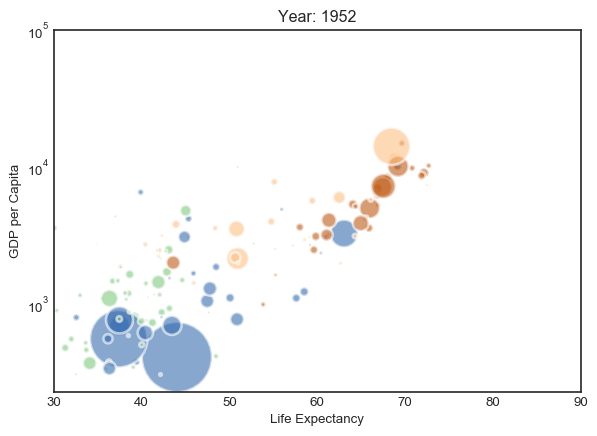

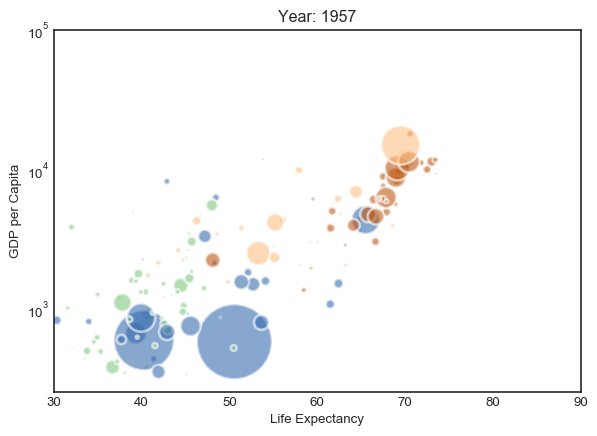

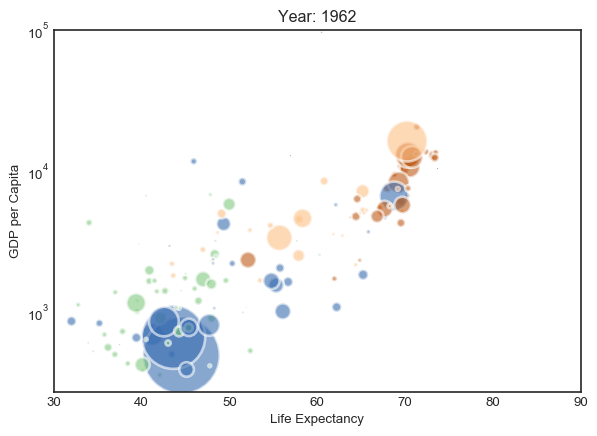

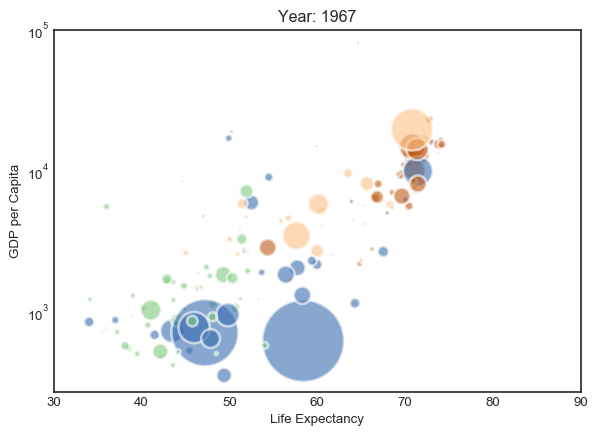

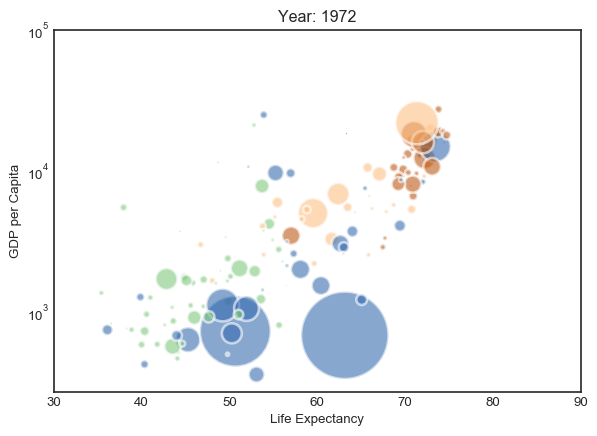

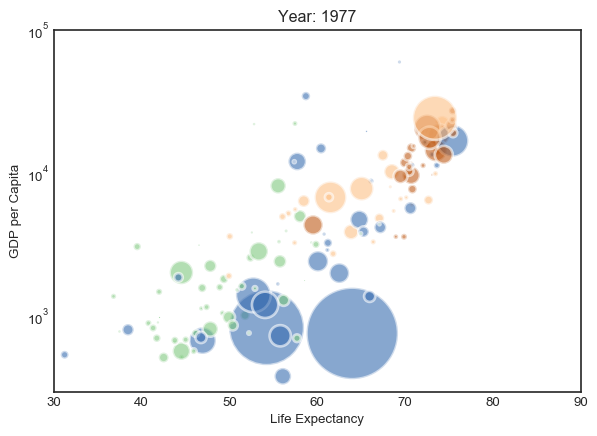

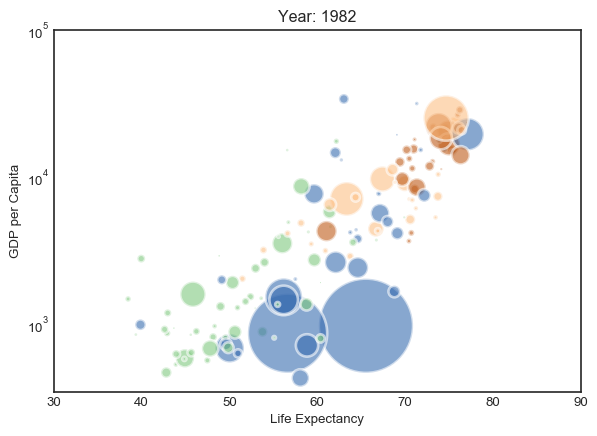

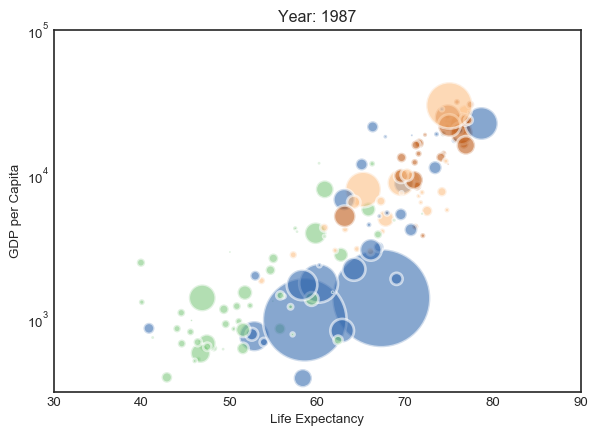

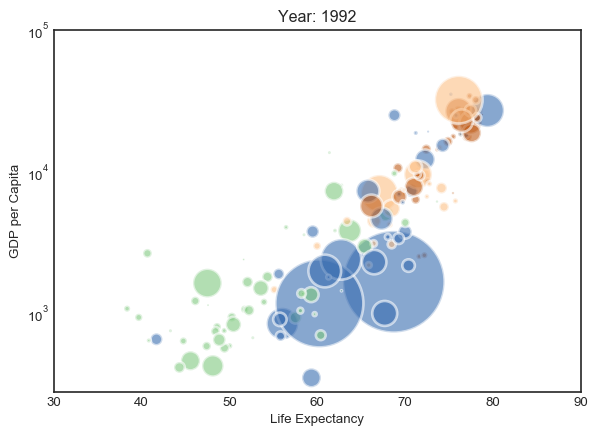

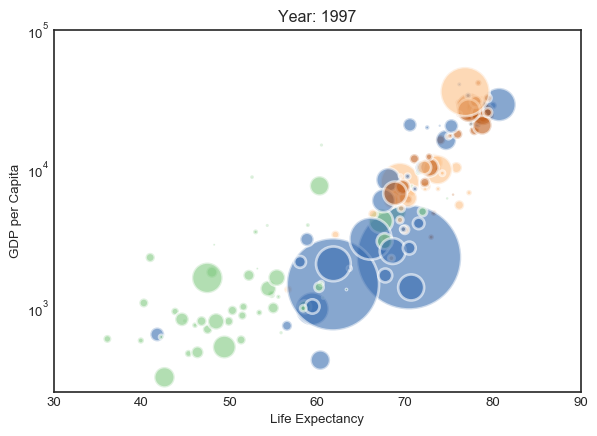

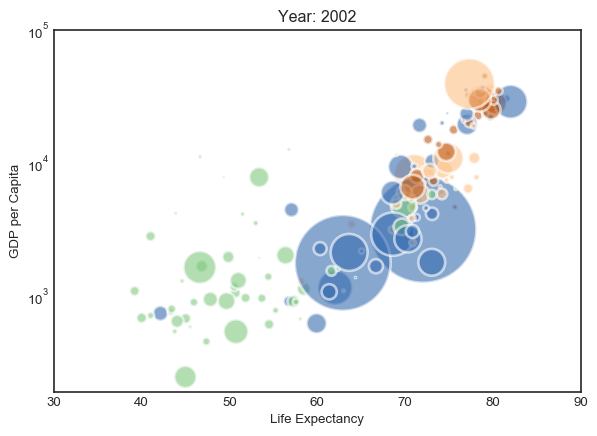

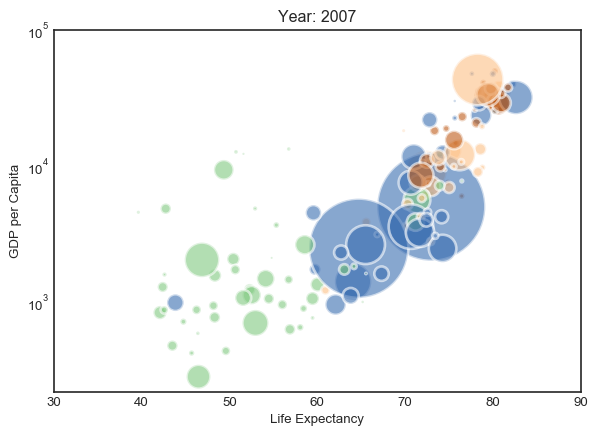

In [111]:
# For each year:
for i in data.year.unique():
 
    # initialize a figure
    fig = plt.figure(figsize=(680/my_dpi, 480/my_dpi), dpi=my_dpi)
 
    # Change color with c and alpha. I map the color to the X axis value.
    tmp=data[ data.year == i ]
    plt.scatter(tmp['lifeExp'], tmp['gdpPercap'] , s=tmp['pop']/200000 , c=tmp['continent'].cat.codes, cmap="Accent", alpha=0.6, edgecolors="white", linewidth=2)
 
    # Add titles (main and on axis)
    plt.yscale('log')
    plt.xlabel("Life Expectancy")
    plt.ylabel("GDP per Capita")
    plt.title("Year: "+str(i) )
    plt.ylim(0,100000)
    plt.xlim(30, 90)

    # Save it
    filename='Gapminder_step'+str(i)+'.png'
    plt.savefig(filename, dpi=96)
    plt.gca()
#Transformation in a GIF using Image Magick

# Then use image magick (this is bash, not python)
#convert -delay 80 Gapminder*.png animated_gapminder.gif


In [149]:
protests = pd.read_csv(DATA_PATH + 'protests_location.csv')
protests.head()

,SQLDATE,ActionGeo_Lat,ActionGeo_Long,EventCode,ActionGeo_FullName
0,20160520,42.50000,19.3000,1411,Montenegro
1,20160520,42.50000,19.3000,1411,Montenegro
2,20160520,50.50000,4.7500,1412,"Wallonia, Waals Gewest, Belgium"
3,20160520,50.50000,4.7500,1412,"Wallonia, Waals Gewest, Belgium"
4,20160520,-1.80409,37.6203,1411,"Makueni, Eastern, Kenya"


In [150]:
protests['SQLDATE'] = protests['SQLDATE'].astype(str)
protests['SQLDATE'] = protests['SQLDATE'].str[0:4]
protests['ActionGeo_FullName'] = protests['ActionGeo_FullName'].str.split(', ').str[-1]
protests.head()

,SQLDATE,ActionGeo_Lat,ActionGeo_Long,EventCode,ActionGeo_FullName
0,2016,42.50000,19.3000,1411,Montenegro
1,2016,42.50000,19.3000,1411,Montenegro
2,2016,50.50000,4.7500,1412,Belgium
3,2016,50.50000,4.7500,1412,Belgium
4,2016,-1.80409,37.6203,1411,Kenya


In [151]:
protests = protests.drop('ActionGeo_Lat', 1)
protests = protests.drop('ActionGeo_Long', 1)
protests.head()

,SQLDATE,EventCode,ActionGeo_FullName
0,2016,1411,Montenegro
1,2016,1411,Montenegro
2,2016,1412,Belgium
3,2016,1412,Belgium
4,2016,1411,Kenya


In [152]:
protests=protests.groupby(['ActionGeo_FullName', 'SQLDATE']).agg(['count'])
protests.head(20)

EventCode
                               count
ActionGeo_FullName SQLDATE          
,                  2015           34
                   2016           16
                   2017           22
                   2018           35
Afghanistan        2005            8
                   2008            2
                   2014            9
                   2015         3573
                   2016         5220
                   2017         2441
                   2018         2196
Albania            2014            1
                   2015          597
                   2016         2096
                   2017         2122
                   2018         2589
Algeria            2014            4
                   2015         1474
                   2016         1611
                   2017          946

In [154]:
protests = protests.reset_index()
protests = protests[4:]
protests.head(20)
protests.groupby(['SQLDATE']).agg(['count'])


C:\Users\antho\Anaconda3\lib\site-packages\pandas\core\generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,index,ActionGeo_FullName,EventCode
,,,count
,count,count,count
SQLDATE,,,
2005,15,15,15
2006,17,17,17
2007,8,8,8
2008,11,11,11
2014,159,159,159
2015,236,236,236
2016,237,237,237
